In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Core imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms

import timm
import os
import json
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("\n" + "="*70)
print("COMBINED DATASET TRAINING (MAIN + OTTAKSHARAS)")
print("="*70)

# Kaggle API Setup
kaggle_username = input("Enter your Kaggle username: ")
kaggle_key = input("Enter your Kaggle API key: ")

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod("/root/.kaggle/kaggle.json", 600)
print("\nKaggle API configured successfully")

CUDA available: True
Device name: Tesla P100-PCIE-16GB
Using device: cuda

COMBINED DATASET TRAINING (MAIN + OTTAKSHARAS)


Enter your Kaggle username:  shraddhaatreya
Enter your Kaggle API key:  d7a68472a232d02050233965ab6187b4



Kaggle API configured successfully


In [2]:
!pip install -q kaggle

print("Downloading datasets from Kaggle...\n")

# Download main aksharas
print("1. Downloading main aksharas dataset...")
!kaggle datasets download -d sahilkumarjamwal/handwritten-kannada-main-aksharas -p /kaggle/working

# Download ottaksharas
print("\n2. Downloading ottaksharas dataset...")
!kaggle datasets download -d sahilkumarjamwal/handwritten-kannada-ottaksharas -p /kaggle/working

print("\n" + "="*70)
print("Extracting datasets...")
print("="*70)

# Unzip main aksharas
print("\nExtracting main aksharas...")
!unzip -qo /kaggle/working/handwritten-kannada-main-aksharas.zip -d /kaggle/working/kannada_main

# Unzip ottaksharas
print("Extracting ottaksharas...")
!unzip -qo /kaggle/working/handwritten-kannada-ottaksharas.zip -d /kaggle/working/kannada_ottaksharas

print("\n✅ Both datasets downloaded and extracted")
print("="*70)

# Verify extraction
print("\nVerifying dataset locations...")
!ls /kaggle/working/kannada_main
print("\n")
!ls /kaggle/working/kannada_ottaksharas


1. Downloading main aksharas dataset...
Dataset URL: https://www.kaggle.com/datasets/sahilkumarjamwal/handwritten-kannada-main-aksharas
License(s): apache-2.0
 96%|██████████████████████████████████████▍ | 353M/368M [00:00<00:00, 1.23GB/s]
100%|████████████████████████████████████████| 368M/368M [00:00<00:00, 1.23GB/s]

2. Downloading ottaksharas dataset...
Dataset URL: https://www.kaggle.com/datasets/sahilkumarjamwal/handwritten-kannada-ottaksharas
License(s): apache-2.0
  0%|                                               | 0.00/11.1M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 11.1M/11.1M [00:00<00:00, 1.06GB/s]

Extracting datasets...

Extracting main aksharas...
Extracting ottaksharas...

✅ Both datasets downloaded and extracted

Verifying dataset locations...
handwritten-kannada-characters-main


handwritten-kannada-characters-ottaksharas


In [4]:
import os

print("Locating dataset paths...\n")

# Main aksharas path (already found)
main_path = "/kaggle/working/kannada_main/handwritten-kannada-characters-main/Characters"
print(f"✓ Main aksharas at: {main_path}")
print(f"  Number of classes: {len(os.listdir(main_path))}")

# Correct ottaksharas path based on your output
otta_path = "/kaggle/working/kannada_ottaksharas/handwritten-kannada-characters-ottaksharas/Characters"

if os.path.exists(otta_path):
    print(f"\n✓ Ottaksharas at: {otta_path}")
    print(f"  Number of classes: {len(os.listdir(otta_path))}")
else:
    print(f"\n✗ Path doesn't exist: {otta_path}")
    print("Checking alternatives...")
    !ls /kaggle/working/kannada_ottaksharas/handwritten-kannada-characters-ottaksharas/

# Verify both datasets
if os.path.exists(main_path) and os.path.exists(otta_path):
    main_classes = len(os.listdir(main_path))
    otta_classes = len(os.listdir(otta_path))
    
    print("\n" + "="*70)
    print("DATASET SUMMARY")
    print("="*70)
    print(f"Main aksharas: {main_classes} classes")
    print(f"Ottaksharas: {otta_classes} classes")
    print(f"Total classes (combined): {main_classes + otta_classes}")
    print("="*70)
    
    # Sample some class names
    print("\nSample main akshara classes:", os.listdir(main_path)[:5])
    print("Sample ottakshara classes:", os.listdir(otta_path)[:5])
else:
    print("\n⚠️ Could not locate one or both datasets")

Locating dataset paths...

✓ Main aksharas at: /kaggle/working/kannada_main/handwritten-kannada-characters-main/Characters
  Number of classes: 588

✓ Ottaksharas at: /kaggle/working/kannada_ottaksharas/handwritten-kannada-characters-ottaksharas/Characters
  Number of classes: 35

DATASET SUMMARY
Main aksharas: 588 classes
Ottaksharas: 35 classes
Total classes (combined): 623

Sample main akshara classes: ['130', '148', '265', '2', '371']
Sample ottakshara classes: ['2', '11', '22', '8', '6']


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import shutil

print("="*70)
print("CREATING COMBINED DATASET")
print("="*70)

# Data transforms (same as before)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load both datasets separately first
print("\nLoading main aksharas dataset...")
main_dataset = datasets.ImageFolder(root=main_path, transform=transform)
print(f"Main dataset: {len(main_dataset)} images, {len(main_dataset.classes)} classes")

print("\nLoading ottaksharas dataset...")
otta_dataset = datasets.ImageFolder(root=otta_path, transform=transform)
print(f"Ottaksharas dataset: {len(otta_dataset)} images, {len(otta_dataset.classes)} classes")

# Adjust ottaksharas labels to avoid overlap with main dataset
print("\nAdjusting ottaksharas class labels to avoid overlap...")
num_main_classes = len(main_dataset.classes)

# Create new dataset with adjusted labels for ottaksharas
adjusted_otta_samples = []
for img_path, label in otta_dataset.samples:
    adjusted_label = label + num_main_classes  # Shift labels
    adjusted_otta_samples.append((img_path, adjusted_label))

# Replace ottaksharas samples with adjusted ones
otta_dataset.samples = adjusted_otta_samples
otta_dataset.targets = [s[1] for s in adjusted_otta_samples]

print(f"Ottaksharas labels shifted from 0-{len(otta_dataset.classes)-1} to {num_main_classes}-{num_main_classes + len(otta_dataset.classes)-1}")

# Concatenate datasets
print("\nCombining datasets...")
combined_dataset = ConcatDataset([main_dataset, otta_dataset])

# Create combined class names
combined_classes = main_dataset.classes + [f"otta_{c}" for c in otta_dataset.classes]

print("\n" + "="*70)
print("COMBINED DATASET CREATED")
print("="*70)
print(f"Total images: {len(combined_dataset):,}")
print(f"Total classes: {len(combined_classes)}")
print(f"  - Main aksharas: {len(main_dataset.classes)} classes ({len(main_dataset):,} images)")
print(f"  - Ottaksharas: {len(otta_dataset.classes)} classes ({len(otta_dataset):,} images)")
print("="*70)

CREATING COMBINED DATASET

Loading main aksharas dataset...
Main dataset: 146556 images, 587 classes

Loading ottaksharas dataset...
Ottaksharas dataset: 8500 images, 34 classes

Adjusting ottaksharas class labels to avoid overlap...
Ottaksharas labels shifted from 0-33 to 587-620

Combining datasets...

COMBINED DATASET CREATED
Total images: 155,056
Total classes: 621
  - Main aksharas: 587 classes (146,556 images)
  - Ottaksharas: 34 classes (8,500 images)


In [7]:
from sklearn.model_selection import train_test_split
from collections import Counter

print("Creating stratified train-validation split...")
print("="*70)

# Fast way to get all targets
print("Extracting targets from combined dataset...")

# Main dataset targets (0-586)
main_targets = [s[1] for s in main_dataset.samples]

# Ottaksharas targets (already adjusted to 587-620)
otta_targets = [s[1] for s in otta_dataset.samples]

# Combine
all_targets = np.array(main_targets + otta_targets)

print(f"Total samples: {len(all_targets):,}")
print(f"Unique classes: {len(np.unique(all_targets))}")

# Check class distribution
class_counts = Counter(all_targets)
print(f"\nClass distribution:")
print(f"  Min samples per class: {min(class_counts.values())}")
print(f"  Max samples per class: {max(class_counts.values())}")
print(f"  Avg samples per class: {np.mean(list(class_counts.values())):.1f}")

# Perform stratified split (80/20)
print("\nPerforming stratified split...")
train_idx, val_idx = train_test_split(
    np.arange(len(all_targets)),
    test_size=0.2,
    stratify=all_targets,
    random_state=42
)

# Create subsets
train_dataset = Subset(combined_dataset, train_idx)
val_dataset = Subset(combined_dataset, val_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Verify split
train_targets = [all_targets[i] for i in train_idx]
val_targets = [all_targets[i] for i in val_idx]

print("\n" + "="*70)
print("STRATIFIED SPLIT COMPLETE")
print("="*70)
print(f"Training samples: {len(train_dataset):,} (80%)")
print(f"Validation samples: {len(val_dataset):,} (20%)")
print(f"Classes in training: {len(set(train_targets))}")
print(f"Classes in validation: {len(set(val_targets))}")
print("="*70)
print("Ready for model training on combined dataset!")

# Store for later use
num_classes_combined = len(combined_classes)
print(f"\nTotal classes for model: {num_classes_combined}")

Creating stratified train-validation split...
Extracting targets from combined dataset...
Total samples: 155,056
Unique classes: 621

Class distribution:
  Min samples per class: 240
  Max samples per class: 250
  Avg samples per class: 249.7

Performing stratified split...

STRATIFIED SPLIT COMPLETE
Training samples: 124,044 (80%)
Validation samples: 31,012 (20%)
Classes in training: 621
Classes in validation: 621
Ready for model training on combined dataset!

Total classes for model: 621


In [8]:
import timm

# Load Swin Transformer for combined dataset
model_name = 'swin_tiny_patch4_window7_224'

# Create model with 621 classes (587 main + 34 ottaksharas)
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes_combined)
model = model.to(device)

print("="*70)
print("MODEL CONFIGURATION - COMBINED DATASET")
print("="*70)
print(f"Model: {model_name}")
print(f"Number of classes: {num_classes_combined}")
print(f"  - Main aksharas: 587 classes")
print(f"  - Ottaksharas: 34 classes")
print(f"Device: {device}")
print("-"*70)

# Check parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("="*70)
print("Swin Transformer loaded for combined dataset!")

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

MODEL CONFIGURATION - COMBINED DATASET
Model: swin_tiny_patch4_window7_224
Number of classes: 621
  - Main aksharas: 587 classes
  - Ottaksharas: 34 classes
Device: cuda
----------------------------------------------------------------------
Total parameters: 27,996,903
Trainable parameters: 27,996,903
Swin Transformer loaded for combined dataset!


In [9]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# Learning rate scheduler
num_epochs = 7  # More epochs for combined dataset with ottaksharas
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("="*70)
print("TRAINING CONFIGURATION - COMBINED DATASET")
print("="*70)
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: AdamW (lr=1e-4, weight_decay=0.05)")
print(f"Scheduler: CosineAnnealingLR")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: 32")
print(f"Estimated training time: ~{num_epochs * 25} minutes (~3 hours)")
print("="*70)
print("Configuration ready for training!")

TRAINING CONFIGURATION - COMBINED DATASET
Loss function: CrossEntropyLoss
Optimizer: AdamW (lr=1e-4, weight_decay=0.05)
Scheduler: CosineAnnealingLR
Number of epochs: 7
Batch size: 32
Estimated training time: ~175 minutes (~3 hours)
Configuration ready for training!


In [10]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{running_loss/total:.4f}', 
                         'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': f'{running_loss/total:.4f}', 
                             'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("Training and validation functions defined successfully!")

Training and validation functions defined successfully!


In [11]:
# Training history
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

print("="*70)
print("STARTING TRAINING - COMBINED DATASET (MAIN + OTTAKSHARAS)")
print("="*70)
print(f"Total epochs: {num_epochs}")
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Estimated time: ~{num_epochs * 25} minutes")
print("="*70 + "\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Step scheduler
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_swin_combined_kannada.pth')
        print(f"Best model saved! (Val Acc: {best_val_acc:.2f}%)")
    
    print("\n")

print("="*70)
print("TRAINING COMPLETED!")
print("="*70)
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved as: best_swin_combined_kannada.pth")
print("="*70)

STARTING TRAINING - COMBINED DATASET (MAIN + OTTAKSHARAS)
Total epochs: 7
Training samples: 124,044
Validation samples: 31,012
Estimated time: ~175 minutes

Epoch 1/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:29<00:00, 10.87it/s, loss=0.0039, acc=96.29%]



Epoch 1 Summary:
Train Loss: 1.0857 | Train Acc: 79.34%
Val Loss: 0.1256 | Val Acc: 96.29%
Learning Rate: 0.000095
Best model saved! (Val Acc: 96.29%)


Epoch 2/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:29<00:00, 10.89it/s, loss=0.0023, acc=97.71%]



Epoch 2 Summary:
Train Loss: 0.1189 | Train Acc: 96.83%
Val Loss: 0.0748 | Val Acc: 97.71%
Learning Rate: 0.000081
Best model saved! (Val Acc: 97.71%)


Epoch 3/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:28<00:00, 10.91it/s, loss=0.0011, acc=98.90%]



Epoch 3 Summary:
Train Loss: 0.0700 | Train Acc: 98.07%
Val Loss: 0.0365 | Val Acc: 98.90%
Learning Rate: 0.000061
Best model saved! (Val Acc: 98.90%)


Epoch 4/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:29<00:00, 10.90it/s, loss=0.0011, acc=98.87%]



Epoch 4 Summary:
Train Loss: 0.0419 | Train Acc: 98.86%
Val Loss: 0.0350 | Val Acc: 98.87%
Learning Rate: 0.000039


Epoch 5/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:29<00:00, 10.87it/s, loss=0.0004, acc=99.56%]



Epoch 5 Summary:
Train Loss: 0.0201 | Train Acc: 99.47%
Val Loss: 0.0127 | Val Acc: 99.56%
Learning Rate: 0.000019
Best model saved! (Val Acc: 99.56%)


Epoch 6/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:29<00:00, 10.88it/s, loss=0.0002, acc=99.78%]



Epoch 6 Summary:
Train Loss: 0.0088 | Train Acc: 99.83%
Val Loss: 0.0064 | Val Acc: 99.78%
Learning Rate: 0.000005
Best model saved! (Val Acc: 99.78%)


Epoch 7/7
--------------------------------------------------


Validation: 100%|██████████| 970/970 [01:28<00:00, 10.90it/s, loss=0.0002, acc=99.86%]



Epoch 7 Summary:
Train Loss: 0.0049 | Train Acc: 99.94%
Val Loss: 0.0049 | Val Acc: 99.86%
Learning Rate: 0.000000
Best model saved! (Val Acc: 99.86%)


TRAINING COMPLETED!
Best validation accuracy: 99.86%
Model saved as: best_swin_combined_kannada.pth


In [12]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np

print("="*80)
print("CALCULATING PERFORMANCE METRICS - COMBINED DATASET")
print("="*80)

# Get predictions on validation set
model.eval()
all_preds = []
all_labels = []

print("\nCollecting predictions from validation set...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate overall metrics
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

accuracy = 100. * (all_preds == all_labels).sum() / len(all_labels)

print(f"\n{'='*80}")
print(f"PERFORMANCE METRICS - SWIN TRANSFORMER (COMBINED)")
print(f"{'='*80}")
print(f"Validation Accuracy:    {accuracy:.2f}%")
print(f"Weighted Precision:     {precision:.4f}")
print(f"Weighted Recall:        {recall:.4f}")
print(f"Weighted F1-Score:      {f1:.4f}")
print(f"{'='*80}")

# Separate metrics for main vs ottaksharas
main_mask = all_labels < 587
otta_mask = all_labels >= 587

main_acc = 100. * (all_preds[main_mask] == all_labels[main_mask]).sum() / main_mask.sum()
otta_acc = 100. * (all_preds[otta_mask] == all_labels[otta_mask]).sum() / otta_mask.sum()

print(f"\nSEPARATE PERFORMANCE:")
print(f"Main Aksharas (587 classes): {main_acc:.2f}%")
print(f"Ottaksharas (34 classes):    {otta_acc:.2f}%")
print(f"{'='*80}")

# Store metrics
swin_combined_metrics = {
    'model_name': 'Swin Transformer (Combined)',
    'train_acc': train_accs[-1],
    'val_acc': val_accs[-1],
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1],
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'main_acc': main_acc,
    'otta_acc': otta_acc,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'all_preds': all_preds,
    'all_labels': all_labels
}

print("\nMetrics stored in 'swin_combined_metrics' dictionary")
print("="*80)

CALCULATING PERFORMANCE METRICS - COMBINED DATASET



Evaluating: 100%|██████████| 970/970 [01:27<00:00, 11.04it/s]


PERFORMANCE METRICS - SWIN TRANSFORMER (COMBINED)
Validation Accuracy:    99.86%
Weighted Precision:     0.9987
Weighted Recall:        0.9986
Weighted F1-Score:      0.9986

SEPARATE PERFORMANCE:
Main Aksharas (587 classes): 99.86%
Ottaksharas (34 classes):    99.94%

Metrics stored in 'swin_combined_metrics' dictionary


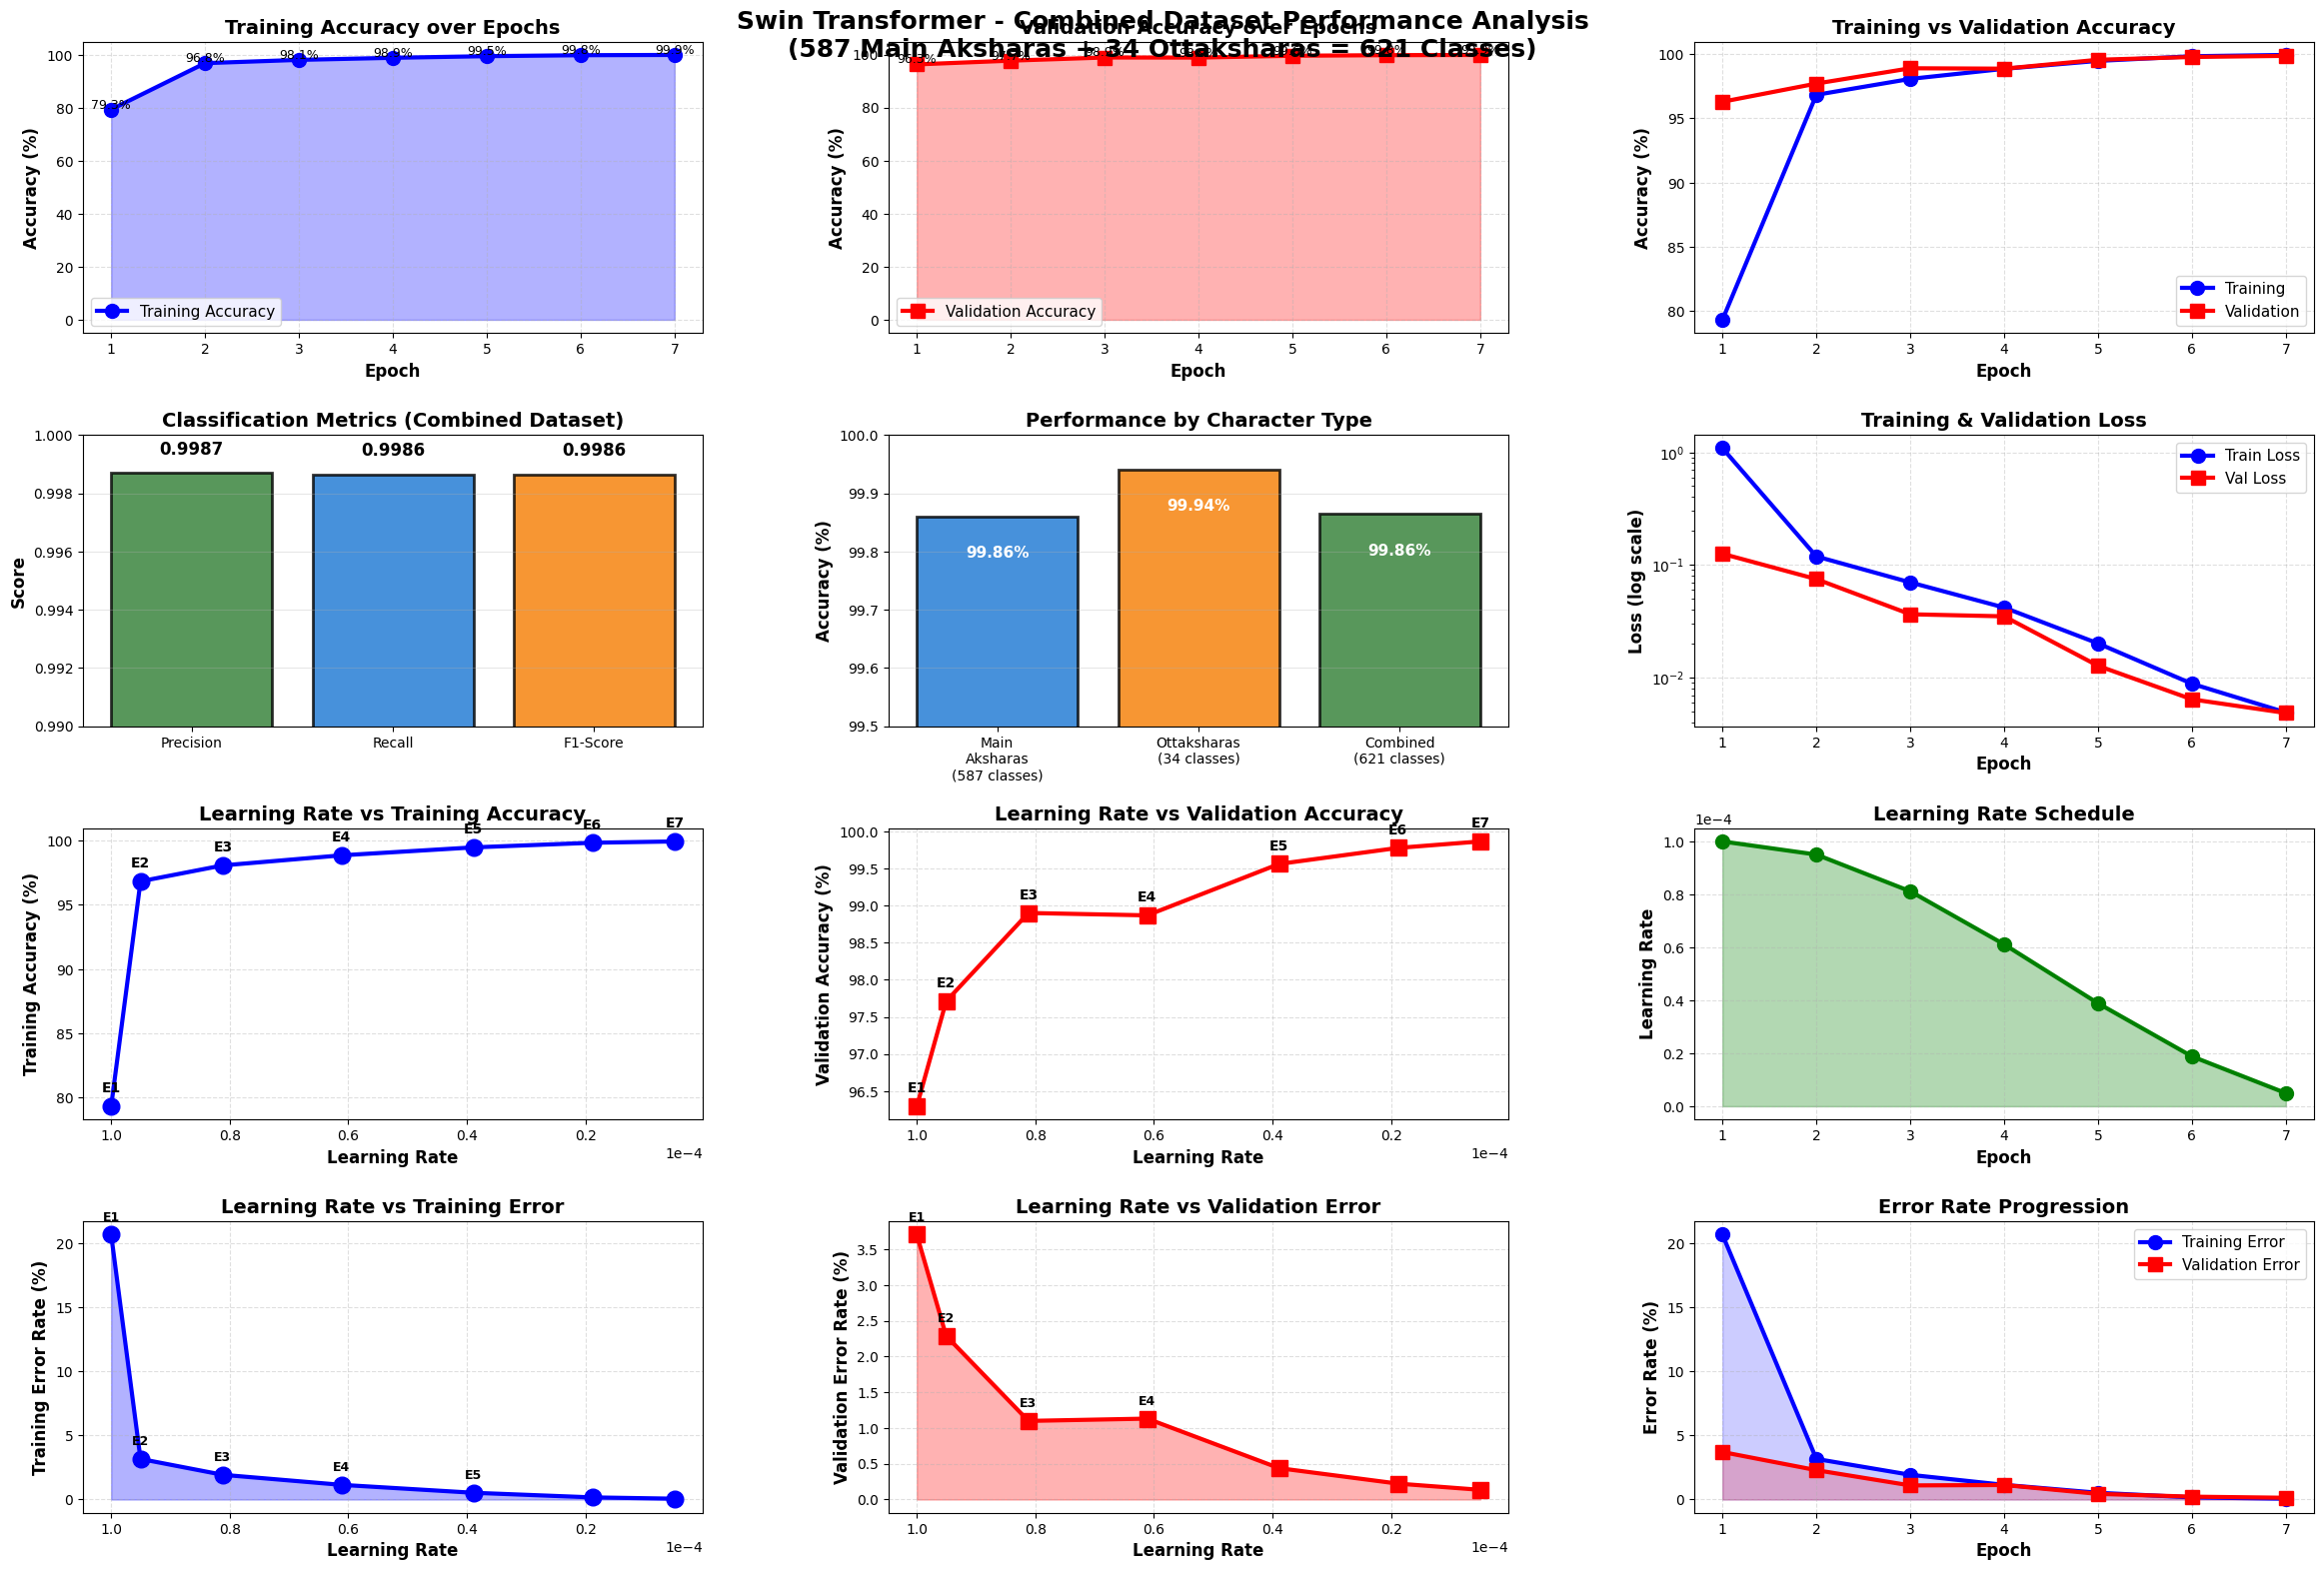


VISUALIZATION COMPLETE
Saved as: swin_combined_performance_analysis.png


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive figure
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3, top=0.96, bottom=0.04, left=0.05, right=0.98)

lr_history = [0.0001 * 0.5 * (1 + np.cos(np.pi * epoch / num_epochs)) for epoch in range(num_epochs)]
epochs = range(1, num_epochs + 1)
train_error = [100 - acc for acc in train_accs]
val_error = [100 - acc for acc in val_accs]

# ========== ROW 1: ACCURACY METRICS ==========

# Plot 1: Training Accuracy
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, train_accs, 'b-o', linewidth=3, markersize=10, label='Training Accuracy')
ax1.fill_between(epochs, train_accs, alpha=0.3, color='blue')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Training Accuracy over Epochs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.4, linestyle='--')
for i, acc in enumerate(train_accs):
    ax1.text(i+1, acc+0.5, f'{acc:.1f}%', ha='center', fontsize=9)

# Plot 2: Validation Accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs, val_accs, 'r-s', linewidth=3, markersize=10, label='Validation Accuracy')
ax2.fill_between(epochs, val_accs, alpha=0.3, color='red')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.4, linestyle='--')
for i, acc in enumerate(val_accs):
    ax2.text(i+1, acc+0.5, f'{acc:.1f}%', ha='center', fontsize=9)

# Plot 3: Training vs Validation Accuracy
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(epochs, train_accs, 'b-o', linewidth=3, markersize=10, label='Training')
ax3.plot(epochs, val_accs, 'r-s', linewidth=3, markersize=10, label='Validation')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.4, linestyle='--')

# ========== ROW 2: PRECISION, RECALL, F1 ==========

# Plot 4: Metrics Bar Chart
ax4 = fig.add_subplot(gs[1, 0])
metrics = ['Precision', 'Recall', 'F1-Score']
values = [swin_combined_metrics['precision'], swin_combined_metrics['recall'], swin_combined_metrics['f1_score']]
colors = ['#2E7D32', '#1976D2', '#F57C00']
bars = ax4.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Classification Metrics (Combined Dataset)', fontsize=14, fontweight='bold')
ax4.set_ylim([0.99, 1.0])
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
             f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 5: Main vs Ottaksharas Performance
ax5 = fig.add_subplot(gs[1, 1])
categories = ['Main\nAksharas\n(587 classes)', 'Ottaksharas\n(34 classes)', 'Combined\n(621 classes)']
accuracies = [swin_combined_metrics['main_acc'], swin_combined_metrics['otta_acc'], accuracy]
colors_comp = ['#1976D2', '#F57C00', '#2E7D32']
bars = ax5.bar(categories, accuracies, color=colors_comp, alpha=0.8, edgecolor='black', linewidth=2)
ax5.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax5.set_title('Performance by Character Type', fontsize=14, fontweight='bold')
ax5.set_ylim([99.5, 100])
ax5.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, accuracies):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height - 0.05,
             f'{val:.2f}%', ha='center', va='top', fontsize=11, fontweight='bold', color='white')

# Plot 6: Training & Validation Loss
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(epochs, train_losses, 'b-o', label='Train Loss', linewidth=3, markersize=10)
ax6.plot(epochs, val_losses, 'r-s', label='Val Loss', linewidth=3, markersize=10)
ax6.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax6.set_ylabel('Loss (log scale)', fontsize=12, fontweight='bold')
ax6.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax6.legend(fontsize=11)
ax6.grid(True, alpha=0.4, linestyle='--')
ax6.set_yscale('log')

# ========== ROW 3: LEARNING RATE ANALYSIS ==========

# Plot 7: LR vs Train Accuracy
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(lr_history, train_accs, 'b-o', linewidth=3, markersize=12)
for i, (lr, acc) in enumerate(zip(lr_history, train_accs)):
    ax7.annotate(f'E{i+1}', (lr, acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10, fontweight='bold')
ax7.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax7.set_ylabel('Training Accuracy (%)', fontsize=12, fontweight='bold')
ax7.set_title('Learning Rate vs Training Accuracy', fontsize=14, fontweight='bold')
ax7.grid(True, alpha=0.4, linestyle='--')
ax7.invert_xaxis()
ax7.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 8: LR vs Val Accuracy
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(lr_history, val_accs, 'r-s', linewidth=3, markersize=12)
for i, (lr, acc) in enumerate(zip(lr_history, val_accs)):
    ax8.annotate(f'E{i+1}', (lr, acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10, fontweight='bold')
ax8.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax8.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax8.set_title('Learning Rate vs Validation Accuracy', fontsize=14, fontweight='bold')
ax8.grid(True, alpha=0.4, linestyle='--')
ax8.invert_xaxis()
ax8.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 9: LR Schedule
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(epochs, lr_history, 'g-o', linewidth=3, markersize=10)
ax9.fill_between(epochs, lr_history, alpha=0.3, color='green')
ax9.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax9.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax9.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax9.grid(True, alpha=0.4, linestyle='--')
ax9.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# ========== ROW 4: ERROR ANALYSIS ==========

# Plot 10: LR vs Train Error
ax10 = fig.add_subplot(gs[3, 0])
ax10.plot(lr_history, train_error, 'b-o', linewidth=3, markersize=12)
ax10.fill_between(lr_history, train_error, alpha=0.3, color='blue')
for i, (lr, err) in enumerate(zip(lr_history, train_error)):
    if err > 0.5:
        ax10.annotate(f'E{i+1}', (lr, err), textcoords="offset points", 
                     xytext=(0,10), ha='center', fontsize=9, fontweight='bold')
ax10.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax10.set_ylabel('Training Error Rate (%)', fontsize=12, fontweight='bold')
ax10.set_title('Learning Rate vs Training Error', fontsize=14, fontweight='bold')
ax10.grid(True, alpha=0.4, linestyle='--')
ax10.invert_xaxis()
ax10.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 11: LR vs Val Error
ax11 = fig.add_subplot(gs[3, 1])
ax11.plot(lr_history, val_error, 'r-s', linewidth=3, markersize=12)
ax11.fill_between(lr_history, val_error, alpha=0.3, color='red')
for i, (lr, err) in enumerate(zip(lr_history, val_error)):
    if err > 0.5:
        ax11.annotate(f'E{i+1}', (lr, err), textcoords="offset points", 
                     xytext=(0,10), ha='center', fontsize=9, fontweight='bold')
ax11.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax11.set_ylabel('Validation Error Rate (%)', fontsize=12, fontweight='bold')
ax11.set_title('Learning Rate vs Validation Error', fontsize=14, fontweight='bold')
ax11.grid(True, alpha=0.4, linestyle='--')
ax11.invert_xaxis()
ax11.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 12: Error over Epochs
ax12 = fig.add_subplot(gs[3, 2])
ax12.plot(epochs, train_error, 'b-o', linewidth=3, markersize=10, label='Training Error')
ax12.plot(epochs, val_error, 'r-s', linewidth=3, markersize=10, label='Validation Error')
ax12.fill_between(epochs, train_error, alpha=0.2, color='blue')
ax12.fill_between(epochs, val_error, alpha=0.2, color='red')
ax12.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax12.set_ylabel('Error Rate (%)', fontsize=12, fontweight='bold')
ax12.set_title('Error Rate Progression', fontsize=14, fontweight='bold')
ax12.legend(fontsize=11)
ax12.grid(True, alpha=0.4, linestyle='--')

# Main title
fig.suptitle('Swin Transformer - Combined Dataset Performance Analysis\n(587 Main Aksharas + 34 Ottaksharas = 621 Classes)', 
             fontsize=18, fontweight='bold')

plt.savefig('swin_combined_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("VISUALIZATION COMPLETE")
print("="*70)
print("Saved as: swin_combined_performance_analysis.png")
print("="*70)

Creating confusion matrix analysis for combined dataset...

Classes with most misclassifications:
Class ID   Type            Class Name                     Total Errors   
----------------------------------------------------------------------
241        Main            315                            4              
574        Main            88                             4              
152        Main            235                            3              
520        Main            567                            2              
192        Main            271                            2              
522        Main            569                            2              
168        Main            25                             2              
263        Main            335                            2              
166        Main            248                            2              
76         Main            167                            2              


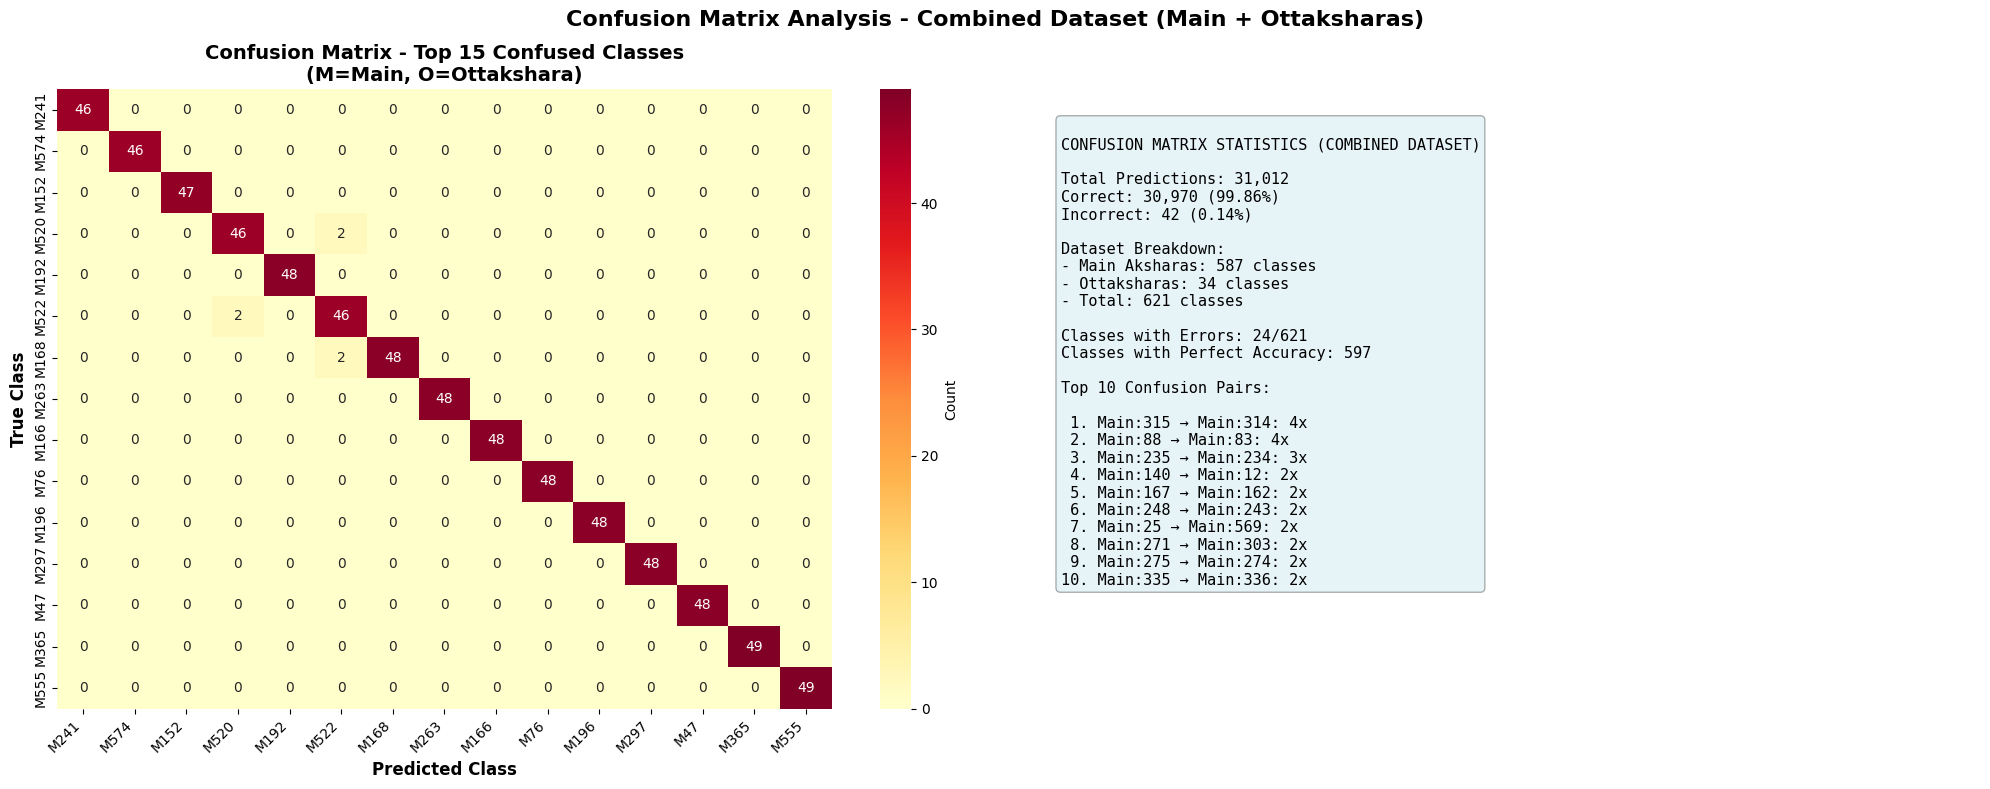


✅ Confusion matrix saved as 'confusion_matrix_combined.png'


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Creating confusion matrix analysis for combined dataset...")

# Get confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Find classes with errors
error_counts = np.sum(cm, axis=1) - np.diag(cm)
top_confused_classes = np.argsort(error_counts)[-20:][::-1]

print(f"\nClasses with most misclassifications:")
print(f"{'Class ID':<10} {'Type':<15} {'Class Name':<30} {'Total Errors':<15}")
print("-" * 70)
for class_id in top_confused_classes[:10]:
    if error_counts[class_id] > 0:
        class_type = "Main" if class_id < 587 else "Ottakshara"
        class_name = combined_classes[class_id][:28]
        print(f"{class_id:<10} {class_type:<15} {class_name:<30} {error_counts[class_id]:<15}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Confusion matrix for top confused classes
if len(top_confused_classes) > 0 and error_counts[top_confused_classes[0]] > 0:
    confused_subset = top_confused_classes[:15]
    cm_subset = cm[np.ix_(confused_subset, confused_subset)]
    
    labels = []
    for idx in confused_subset:
        class_type = "M" if idx < 587 else "O"
        labels.append(f"{class_type}{idx}")
    
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='YlOrRd', ax=ax1,
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix - Top 15 Confused Classes\n(M=Main, O=Ottakshara)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Class', fontsize=12, fontweight='bold')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
else:
    ax1.text(0.5, 0.5, 'Excellent Performance!\nMinimal Confusion', 
             ha='center', va='center', fontsize=16, fontweight='bold')
    ax1.axis('off')

# Plot 2: Statistics
ax2.axis('off')

# Calculate statistics
from scipy.spatial.distance import cdist
total_samples = len(all_labels)
correct = np.sum(all_preds == all_labels)
incorrect = total_samples - correct

# Find most common confusions
confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)

stats_text = f"""
CONFUSION MATRIX STATISTICS (COMBINED DATASET)

Total Predictions: {total_samples:,}
Correct: {correct:,} ({100*correct/total_samples:.2f}%)
Incorrect: {incorrect:,} ({100*incorrect/total_samples:.2f}%)

Dataset Breakdown:
- Main Aksharas: 587 classes
- Ottaksharas: 34 classes
- Total: 621 classes

Classes with Errors: {np.sum(error_counts > 0)}/621
Classes with Perfect Accuracy: {np.sum(error_counts == 0)}

Top 10 Confusion Pairs:
"""

for idx, (true_c, pred_c, count) in enumerate(confusion_pairs[:10], 1):
    true_type = "Main" if true_c < 587 else "Otta"
    pred_type = "Main" if pred_c < 587 else "Otta"
    true_name = combined_classes[true_c][:10]
    pred_name = combined_classes[pred_c][:10]
    stats_text += f"\n{idx:2d}. {true_type}:{true_name} → {pred_type}:{pred_name}: {count}x"

ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('Confusion Matrix Analysis - Combined Dataset (Main + Ottaksharas)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_combined.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrix saved as 'confusion_matrix_combined.png'")

Creating t-SNE visualization for combined dataset...
This will take several minutes...

Extracting features (max 5000 samples)...


Extracting:  16%|█▌        | 157/970 [00:15<01:18, 10.40it/s]



Feature shape: (5024, 37632)
Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5024 samples in 0.081s...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

[t-SNE] Computed neighbors for 5024 samples in 23.137s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5024
[t-SNE] Computed conditional probabilities for sample 2000 / 5024
[t-SNE] Computed conditional probabilities for sample 3000 / 5024
[t-SNE] Computed conditional probabilities for sample 4000 / 5024
[t-SNE] Computed conditional probabilities for sample 5000 / 5024
[t-SNE] Computed conditional probabilities for sample 5024 / 5024
[t-SNE] Mean sigma: 208.675710
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.475174
[t-SNE] KL divergence after 1000 iterations: 0.985746

t-SNE completed! Creating visualization...


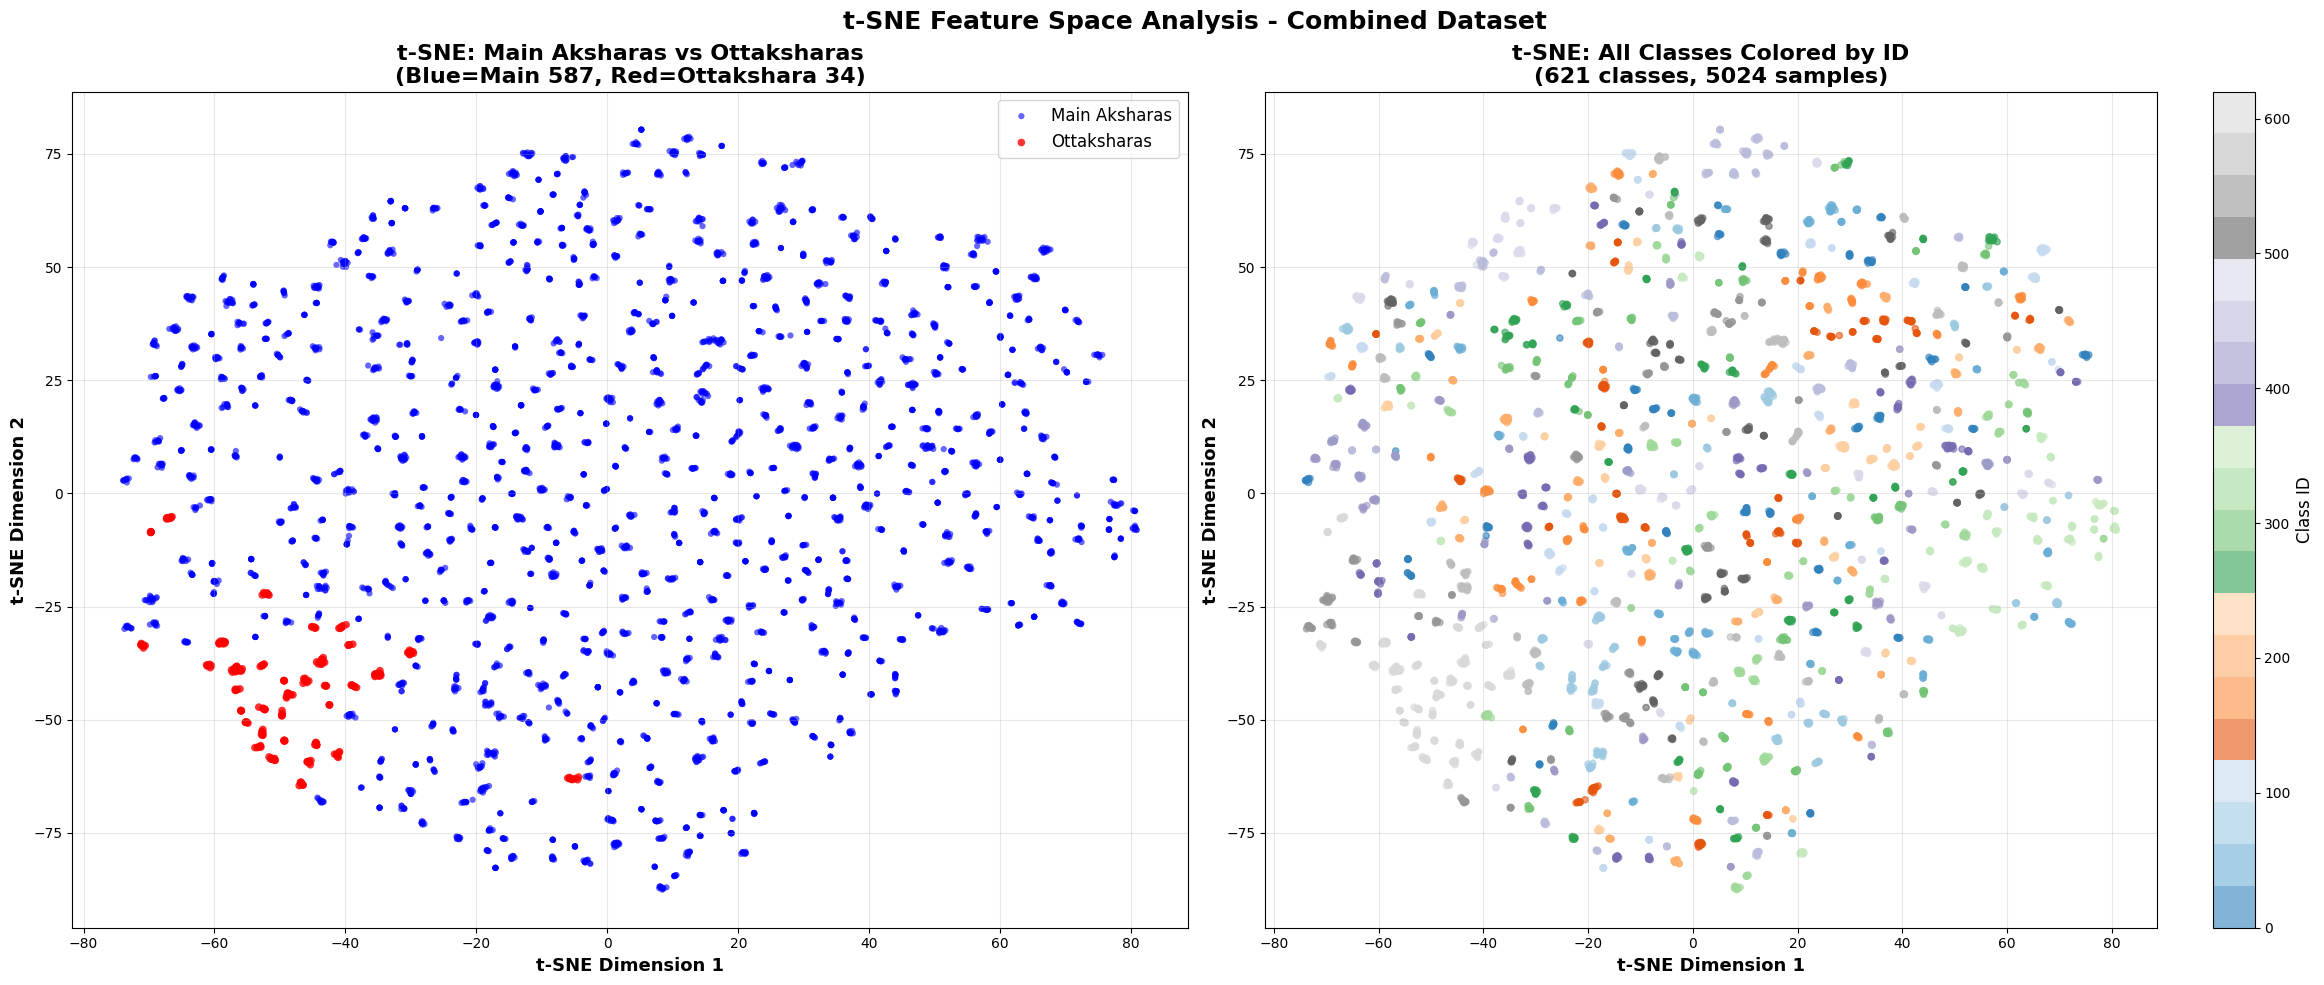


t-SNE ANALYSIS SUMMARY
Total samples visualized: 5024
Total classes: 621
Average inter-cluster distance: 70.11
Average intra-cluster distance: 0.36
Separation ratio (inter/intra): 196.77

Visualization saved as 'tsne_combined_dataset.png'


In [16]:
from sklearn.manifold import TSNE

print("Creating t-SNE visualization for combined dataset...")
print("This will take several minutes...\n")

# Extract features from model
def get_features(model, loader, device, max_samples=5000):
    model.eval()
    features_list = []
    labels_list = []
    
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    
    print(f"Extracting features (max {max_samples} samples)...")
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting"):
            if len(features_list) * loader.batch_size >= max_samples:
                break
                
            images = images.to(device)
            features = feature_extractor(images)
            features = features.view(features.size(0), -1)
            
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())
    
    features = np.vstack(features_list)
    labels = np.concatenate(labels_list)
    return features, labels

# Extract features
val_features, val_labels = get_features(model, val_loader, device, max_samples=5000)

print(f"\nFeature shape: {val_features.shape}")
print("Running t-SNE...")

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(val_features)

print("\nt-SNE completed! Creating visualization...")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Separate main and ottakshara points
main_mask = val_labels < 587
otta_mask = val_labels >= 587

# Plot 1: Colored by type (Main vs Ottakshara)
ax1.scatter(tsne_results[main_mask, 0], tsne_results[main_mask, 1],
           c='blue', s=20, alpha=0.6, label='Main Aksharas', edgecolors='none')
ax1.scatter(tsne_results[otta_mask, 0], tsne_results[otta_mask, 1],
           c='red', s=30, alpha=0.8, label='Ottaksharas', edgecolors='none')
ax1.set_title('t-SNE: Main Aksharas vs Ottaksharas\n(Blue=Main 587, Red=Ottakshara 34)', 
             fontsize=16, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax1.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: All classes colored by ID
scatter = ax2.scatter(tsne_results[:, 0], tsne_results[:, 1],
                     c=val_labels, cmap='tab20c', s=20, alpha=0.6)
ax2.set_title(f't-SNE: All Classes Colored by ID\n({len(np.unique(val_labels))} classes, {len(tsne_results)} samples)', 
             fontsize=16, fontweight='bold')
ax2.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax2.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Class ID', fontsize=12)

plt.suptitle('t-SNE Feature Space Analysis - Combined Dataset', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('tsne_combined_dataset.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate separation metrics
from scipy.spatial.distance import pdist

centroids = {}
for class_id in np.unique(val_labels):
    mask = val_labels == class_id
    if mask.sum() > 0:
        centroids[class_id] = tsne_results[mask].mean(axis=0)

centroid_array = np.array(list(centroids.values()))
inter_distances = cdist(centroid_array, centroid_array)
np.fill_diagonal(inter_distances, np.nan)
avg_inter = np.nanmean(inter_distances)

intra_distances = []
for class_id in np.unique(val_labels):
    mask = val_labels == class_id
    if mask.sum() > 1:
        points = tsne_results[mask]
        centroid = centroids[class_id]
        dists = np.sqrt(((points - centroid)**2).sum(axis=1))
        intra_distances.append(dists.mean())

avg_intra = np.mean(intra_distances)

print("\n" + "="*70)
print("t-SNE ANALYSIS SUMMARY")
print("="*70)
print(f"Total samples visualized: {len(tsne_results)}")
print(f"Total classes: {len(np.unique(val_labels))}")
print(f"Average inter-cluster distance: {avg_inter:.2f}")
print(f"Average intra-cluster distance: {avg_intra:.2f}")
print(f"Separation ratio (inter/intra): {avg_inter/avg_intra:.2f}")
print("="*70)
print("\nVisualization saved as 'tsne_combined_dataset.png'")

PREDICTING YOUR CHARACTER


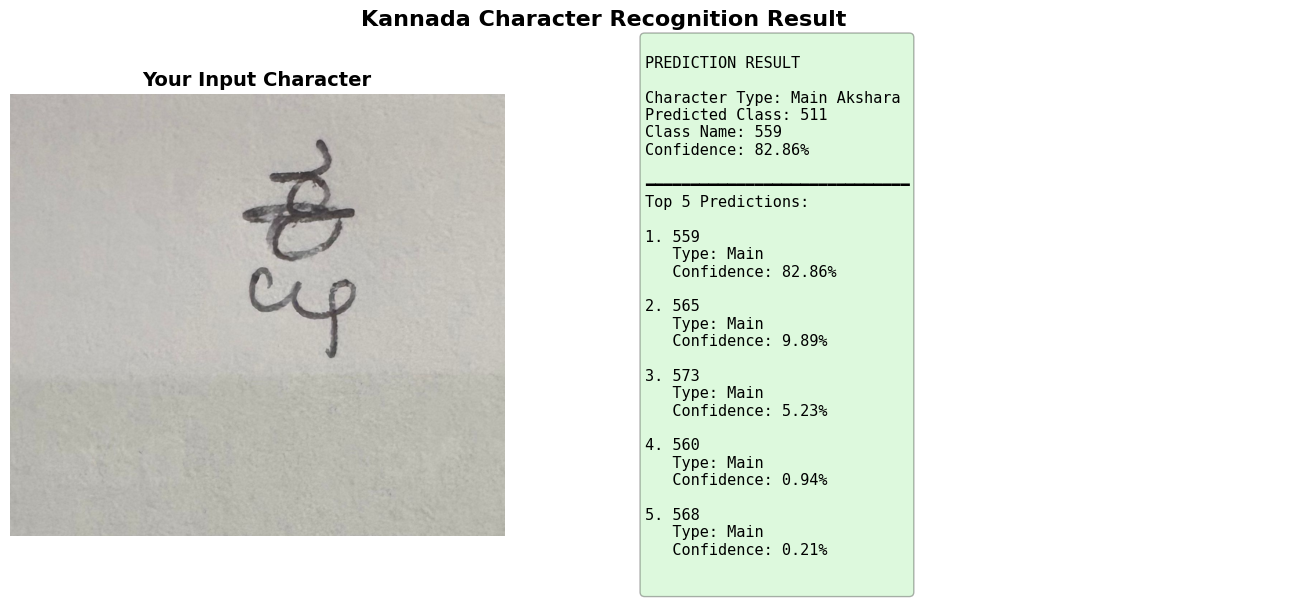


RESULT:
Predicted: 559
Type: Main Akshara
Confidence: 82.86%


In [20]:
from PIL import Image
import matplotlib.pyplot as plt

# Your image path
image_path = "/kaggle/input/kshatest/WhatsApp Image 2025-10-02 at 17.43.37_8b949136.jpg"

print("="*70)
print("PREDICTING YOUR CHARACTER")
print("="*70)

# Load and preprocess image
img = Image.open(image_path).convert('RGB')
original_img = img.copy()

# Apply same transforms as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_tensor = transform(img).unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    probabilities = torch.softmax(output, dim=1)
    confidence, predicted = probabilities.max(1)
    
    # Get top 5 predictions
    top5_conf, top5_pred = probabilities.topk(5, dim=1)

pred_class = predicted.item()
conf_score = confidence.item() * 100

# Determine type
if pred_class < 587:
    char_type = "Main Akshara"
else:
    char_type = "Ottakshara"

class_name = combined_classes[pred_class]

# Display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Show original
ax1.imshow(original_img)
ax1.axis('off')
ax1.set_title('Your Input Character', fontsize=14, fontweight='bold')

# Show prediction
ax2.axis('off')
result_text = f"""
PREDICTION RESULT

Character Type: {char_type}
Predicted Class: {pred_class}
Class Name: {class_name}
Confidence: {conf_score:.2f}%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Top 5 Predictions:

"""

for i in range(5):
    top_class = top5_pred[0][i].item()
    top_conf = top5_conf[0][i].item() * 100
    top_type = "Main" if top_class < 587 else "Otta"
    top_name = combined_classes[top_class]
    result_text += f"{i+1}. {top_name}\n   Type: {top_type}\n   Confidence: {top_conf:.2f}%\n\n"

ax2.text(0.05, 0.5, result_text, fontsize=11, verticalalignment='center',
         fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.suptitle('Kannada Character Recognition Result', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('prediction_result.png', dpi=200, bbox_inches='tight')
plt.show()

print("\nRESULT:")
print(f"Predicted: {class_name}")
print(f"Type: {char_type}")
print(f"Confidence: {conf_score:.2f}%")
print("="*70)

In [19]:
# Search for ಕ್ಷ in your ottakshara classes
print("Ottakshara classes in dataset:")
for i in range(587, 621):
    print(f"Class {i}: {combined_classes[i]}")

Ottakshara classes in dataset:
Class 587: otta_0
Class 588: otta_1
Class 589: otta_10
Class 590: otta_11
Class 591: otta_12
Class 592: otta_13
Class 593: otta_14
Class 594: otta_15
Class 595: otta_16
Class 596: otta_17
Class 597: otta_18
Class 598: otta_19
Class 599: otta_2
Class 600: otta_20
Class 601: otta_21
Class 602: otta_22
Class 603: otta_23
Class 604: otta_24
Class 605: otta_25
Class 606: otta_26
Class 607: otta_27
Class 608: otta_28
Class 609: otta_29
Class 610: otta_3
Class 611: otta_30
Class 612: otta_31
Class 613: otta_32
Class 614: otta_33
Class 615: otta_4
Class 616: otta_5
Class 617: otta_6
Class 618: otta_7
Class 619: otta_8
Class 620: otta_9


Found 1700 ottakshara samples in validation set

Testing ottakshara sample:
Image: /kaggle/working/kannada_ottaksharas/handwritten-kannada-characters-ottaksharas/Characters/14/118.jpg
True class: 593 (otta_14)


/tmp/ipykernel_36/1919721296.py:74: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


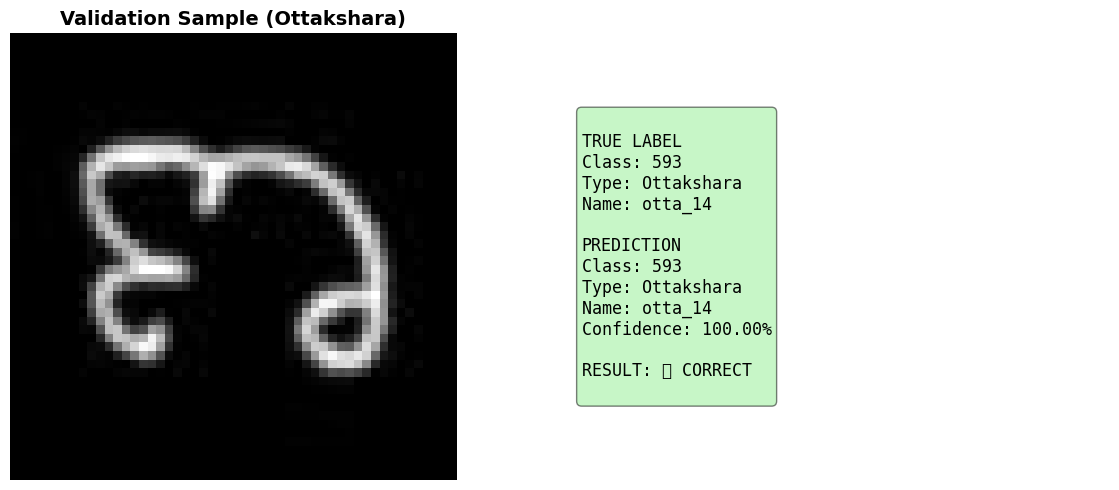


✅ CORRECT!


In [22]:
import random

# Pick a random ottakshara from validation
# Use the labels we collected during metrics calculation
otta_mask = all_labels >= 587
otta_indices = np.where(otta_mask)[0]

print(f"Found {len(otta_indices)} ottakshara samples in validation set")

if len(otta_indices) > 0:
    # Pick random ottakshara sample
    random_idx = random.choice(otta_indices)
    
    # Get the actual dataset index
    dataset_idx = val_dataset.indices[random_idx]
    
    # Get image path and true label
    if dataset_idx < len(main_dataset.samples):
        img_path, true_label = main_dataset.samples[dataset_idx]
    else:
        adjusted_idx = dataset_idx - len(main_dataset.samples)
        img_path, true_label = otta_dataset.samples[adjusted_idx]
    
    print(f"\nTesting ottakshara sample:")
    print(f"Image: {img_path}")
    print(f"True class: {true_label} ({combined_classes[true_label]})")
    
    # Load and predict
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        conf, predicted = probs.max(1)
    
    pred_class = predicted.item()
    confidence = conf.item() * 100
    
    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Validation Sample (Ottakshara)', fontsize=14, fontweight='bold')
    
    ax2.axis('off')
    result = f"""
TRUE LABEL
Class: {true_label}
Type: Ottakshara
Name: {combined_classes[true_label]}

PREDICTION
Class: {pred_class}
Type: {'Ottakshara' if pred_class >= 587 else 'Main Akshara'}
Name: {combined_classes[pred_class]}
Confidence: {confidence:.2f}%

RESULT: {'✅ CORRECT' if pred_class == true_label else '❌ INCORRECT'}
"""
    
    color = 'lightgreen' if pred_class == true_label else 'lightcoral'
    ax2.text(0.1, 0.5, result, fontsize=12, verticalalignment='center',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor=color, alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'✅ CORRECT!' if pred_class == true_label else '❌ INCORRECT'}")
else:
    print("No ottakshara samples found")